# import libraries

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Load the data 

In [150]:
target=pd.read_csv('training_set_labels.csv').sort_values(by='id')
features=pd.read_csv('Training_set_values.csv').sort_values(by='id')


In [151]:
df=target.merge(features,on='id')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0,non functional,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
1,1,functional,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,none,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,2,functional,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,...,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
3,3,functional,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
4,4,non functional,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump


In [153]:
df.ward.value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Izia           1
Igogo          1
Mkumbi         1
Kinungu        1
Nsemulwa       1
Name: ward, Length: 2092, dtype: int64

# Data Cleaning

In [4]:
# check missing values
missing=pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns=['feature','missing_values']
missing

,feature,missing_values
0,id,0
1,status_group,0
2,amount_tsh,0
3,date_recorded,0
4,funder,3635
5,gps_height,0
6,installer,3655
7,longitude,0
8,latitude,0
9,wpt_name,0


In [129]:
# delete the columns which contains more than 20% missing values
col_names=[]
for i in range(len(missing)):
    if missing['missing_values'][i]/len(df)<=0.2:
        col_names.append(missing['feature'][i])
print(col_names)

['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [132]:
# remove all missing data 
df0=df[col_names].dropna(axis=0)
df0.shape

(48288, 40)

# Data Engineering

## Target

In [158]:
# give value for status group and create a new column called target 
df0['target']=df0['status_group'].map({'functional':1,
                                        'functional needs repair':2,
                                        'non functional':0})
df0['target'].value_counts()

1    26517
0    18273
2     3498
Name: target, dtype: int64

## Features

### Create a function to transform non-numerical labels

In [159]:
from sklearn import  preprocessing

In [160]:
def encode(data):
    le = preprocessing.LabelEncoder()
    le.fit(data)
    return le.transform(data)

In [161]:

df0['date_recorded']=df0['date_recorded'].apply(lambda x : x[:4] )

### data transform

In [162]:
df1=df0.copy()

In [163]:
for i in df1.columns:
    df1[i]=encode(df1[i])

In [164]:
df1.info

<bound method DataFrame.info of           id  status_group  amount_tsh  date_recorded  funder  gps_height  \
2          0             0           0              2     708          59   
3          1             0           8              4     372        1697   
4          2             2           0              2     170          59   
5          3             0          17              2    1052          87   
6          4             2           0              3     387          59   
...      ...           ...         ...            ...     ...         ...   
59395  48283             0           0              4    1560        1241   
59396  48284             0           0              2     212          59   
59397  48285             2           0              3     806        1246   
59398  48286             2          17              2    1169        1486   
59399  48287             2          17              4     813        1023   

       installer  longitude  latitude  wpt_

In [165]:
df0[['id','longitude' , 'latitude']].merge(df1[['id','longitude' , 'latitude']],on='id')

,id,longitude_x,latitude_x,longitude_y,latitude_y
0,2,36.115056,-6.279268,28221,20559
1,3,37.147432,-3.187555,45418,16281
2,4,36.164893,-6.099289,11901,31535
3,5,39.286124,-6.972403,28528,17703
4,6,33.229880,-3.852983,27384,20909
...,...,...,...,...,...
31417,48281,31.159952,-6.374470,40708,22141
31418,48282,33.870623,-4.285867,15873,9484
31419,48283,33.095071,-9.224173,32419,37664
31420,48284,37.674448,-3.620035,14724,9668


In [166]:
df2=df1.drop(columns=['id','status_group']) # frop ID and status_group

In [167]:
df2.columns# double check the columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'target'],
      dtype='object')

In [168]:
# 5 first 

# Declare inputs and target

In [169]:
drop_list=['target','num_private','wpt_name','quantity_group','construction_year','management_group','subvillage']

In [170]:
inputs=df2.drop(columns=drop_list)
inputs.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
2,0,2,708,59,781,28012,19758,8,2,0,...,4,5,6,2,2,3,0,0,2,1
3,8,4,372,1697,163,33459,39657,5,6,2,...,4,5,6,2,1,8,6,0,1,1
4,0,2,170,59,188,28221,20559,8,2,0,...,6,6,6,2,0,7,5,0,4,3
5,17,2,1052,87,1162,45418,16281,8,14,23,...,4,5,6,2,1,3,0,0,2,1
6,0,3,387,59,476,11901,31535,0,17,16,...,0,2,6,2,3,7,5,0,6,5


In [171]:
inputs.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [172]:
target=df2.target

# Train test split

In [48]:
x_train, x_test, y_train, y_test = train_test_split(inputs,target, random_state=46,test_size=0.2)

In [49]:
x_train=pd.DataFrame(data=x_train, columns=x_train.columns)
x_test=pd.DataFrame(data=x_test, columns=x_train.columns)

# Feature Selection

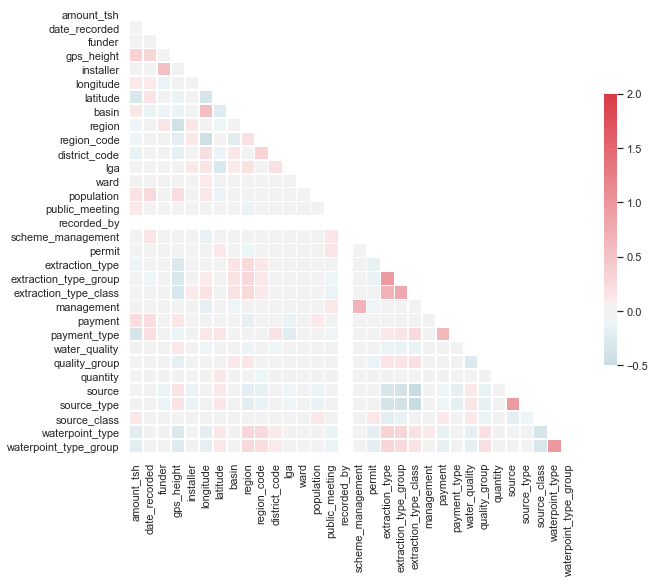

In [50]:

sns.set(style="white")


# Compute the correlation matrix
corr = x_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5})
plt.show()

In [51]:
# Create correlation matrix
corr_matrix = x_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
x_train.drop(columns=to_drop, inplace=True)
x_test.drop(columns=to_drop, inplace=True)
feature_columns=x_train.columns

In [52]:
x_train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
       'source', 'source_type', 'source_class', 'waterpoint_type'],
      dtype='object')

In [53]:
inputs.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [54]:
for i in inputs.columns:
    if i not in x_train.columns:
        print(i)

waterpoint_type_group


In [55]:
#  waterpoint_type_group got removed

# oversampling

In [56]:
from sklearn.utils import resample
# concatenate our training data back together
training  = pd.DataFrame()
training[list(x_train.columns)]=x_train
training['target']=y_train
training.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,target
59246,0,3,437,1317,322,15183,44882,4,9,19,...,6,6,4,4,2,7,5,0,6,0
9551,30,2,615,1623,1606,21167,10647,6,3,10,...,5,3,6,2,1,1,0,0,4,1
10013,0,3,289,59,322,0,46917,4,17,16,...,0,2,6,2,1,7,5,0,4,1
3732,0,4,387,1233,345,3971,19901,2,15,14,...,0,2,6,2,1,3,0,0,4,1
57275,0,2,607,59,322,27211,27059,0,2,0,...,4,5,6,2,1,3,0,0,2,2


In [57]:
# separate minority and majority classes
not_func= training[training.target==0]
func= training[training.target==1]
func_rep= training[training.target==2]

In [58]:
# Get a class count to understand the class imbalance.
print('not funtional count: '+ str(len(not_func)))
print('funtional count: '+ str(len(func)))
print('func_rep count: '+ str(len(func_rep)))

not funtional count: 14675
funtional count: 21181
func_rep count: 2774


In [59]:
# upsample minority
not_func_upsampled = resample(not_func,
                          replace=True, # sample with replacement
                          n_samples=len(func), # match number in majority class
                          random_state=23) # reproducible results
not_func_upsampled.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,target
28142,0,4,212,935,279,27751,2510,7,16,9,...,5,3,6,2,2,7,5,0,6,0
47065,0,2,1528,59,891,27145,20162,8,2,0,...,4,5,4,4,0,3,0,0,1,0
29825,0,3,437,1452,322,16577,45002,4,9,19,...,5,3,6,2,1,7,5,0,6,0
46769,0,4,355,359,415,44275,1168,7,12,25,...,6,6,6,2,0,7,5,0,6,0
54469,0,2,387,59,322,9642,42968,4,13,18,...,0,2,6,2,1,7,5,0,4,0


In [60]:
# upsample minority
func_rep_count_upsampled = resample(func_rep,
                          replace=True, # sample with replacement
                          n_samples=len(func), # match number in majority class
                          random_state=23) # reproducible results
func_rep_count_upsampled.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,target
3374,34,4,501,1035,322,335,25490,3,5,15,...,3,1,6,2,1,6,4,1,2,2
10390,0,3,467,59,554,18188,32403,0,17,16,...,0,2,6,2,3,5,3,1,1,2
28578,30,2,357,1383,462,31071,19971,8,11,4,...,3,1,6,2,1,8,6,0,1,2
21268,25,4,1558,1400,1706,1068,29188,3,5,15,...,3,1,6,2,1,6,4,1,1,2
35067,0,2,1528,59,322,25855,27311,0,2,0,...,4,5,6,2,1,3,0,0,1,2


In [61]:
# combine those datasets
upsampled= pd.concat([func, not_func_upsampled,func_rep_count_upsampled])
upsampled.target.value_counts()

2    21181
1    21181
0    21181
Name: target, dtype: int64

In [62]:
# declare x_train and y_train
y_train = upsampled.target
x_train = upsampled.drop('target', axis=1)

# data standardization 

In [63]:
#import library for data standardization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()  
scaler.fit(x_train)

X_train = scaler.transform(x_train)  
X_test = scaler.transform(x_test)  

## gridsearch

In [64]:
from sklearn.model_selection import RandomizedSearchCV

In [65]:
# given prameters different values
random_grid={
             'n_estimators':list(range(300,400,10)),
             'max_depth':list(range(1,30,2)),
             'max_features':list(range(1,19)),
             'min_samples_leaf':list(range(1,19)),
             'min_samples_split':list(range(1,19))                   
                            
                                
            }

In [66]:
# random forest model
rfc=RandomForestClassifier(
                             n_jobs=-1,
                             random_state=42,
                             verbose=10
    
)

In [67]:
# randommized searchCV
RS=RandomizedSearchCV(rfc,random_grid,cv=10)


In [68]:
# fit the train data
RS.fit(X_train,y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elap

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | ela

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | ela

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elap

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0982s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0126s.) Setting batch_size=126.
/Users/yingyuxuan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yingyuxuan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator f

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | ela

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | ela

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | ela

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elap

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapse

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 370 out of 370 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1638s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 120 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | ela

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1709s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elaps

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1530s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 146

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1447s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 2

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1606s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 17

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1962s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 120 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1305s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 300 tas

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 350building tree 2 of 350
building tree 3 of 350

building tree 4 of 350
building tree 5 of 350
building tree 6 of 350
building tree 7 of 350
building tree 8 of 350


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s


building tree 9 of 350
building tree 10 of 350
building tree 11 of 350
building tree 12 of 350
building tree 13 of 350
building tree 14 of 350
building tree 15 of 350


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s


building tree 16 of 350
building tree 17 of 350
building tree 18 of 350
building tree 19 of 350
building tree 20 of 350


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s


building tree 21 of 350
building tree 22 of 350
building tree 23 of 350
building tree 24 of 350
building tree 25 of 350
building tree 26 of 350
building tree 27 of 350
building tree 28 of 350


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 29 of 350
building tree 30 of 350
building tree 31 of 350
building tree 32 of 350
building tree 33 of 350
building tree 34 of 350
building tree 35 of 350
building tree 36 of 350


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s


building tree 37 of 350
building tree 38 of 350
building tree 39 of 350
building tree 40 of 350
building tree 41 of 350
building tree 42 of 350
building tree 43 of 350
building tree 44 of 350
building tree 45 of 350
building tree 46 of 350
building tree 47 of 350


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s


building tree 48 of 350
building tree 49 of 350
building tree 50 of 350
building tree 51 of 350
building tree 52 of 350
building tree 53 of 350
building tree 54 of 350
building tree 55 of 350
building tree 56 of 350


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.7s


building tree 57 of 350building tree 58 of 350

building tree 59 of 350
building tree 60 of 350
building tree 61 of 350
building tree 62 of 350
building tree 63 of 350
building tree 64 of 350
building tree 65 of 350
building tree 66 of 350
building tree 67 of 350
building tree 68 of 350


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.0s


building tree 69 of 350
building tree 70 of 350
building tree 71 of 350
building tree 72 of 350
building tree 73 of 350
building tree 74 of 350
building tree 75 of 350
building tree 76 of 350
building tree 77 of 350
building tree 78 of 350
building tree 79 of 350
building tree 80 of 350


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.6s


building tree 81 of 350
building tree 82 of 350
building tree 83 of 350
building tree 84 of 350
building tree 85 of 350
building tree 86 of 350
building tree 87 of 350
building tree 88 of 350
building tree 89 of 350
building tree 90 of 350
building tree 91 of 350
building tree 92 of 350
building tree 93 of 350
building tree 94 of 350
building tree 95 of 350
building tree 96 of 350


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.0s


building tree 97 of 350building tree 98 of 350

building tree 99 of 350
building tree 100 of 350
building tree 101 of 350
building tree 102 of 350
building tree 103 of 350
building tree 104 of 350
building tree 105 of 350
building tree 106 of 350building tree 107 of 350

building tree 108 of 350


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.9s


building tree 109 of 350
building tree 110 of 350
building tree 111 of 350
building tree 112 of 350
building tree 113 of 350
building tree 114 of 350
building tree 115 of 350
building tree 116 of 350
building tree 117 of 350
building tree 118 of 350
building tree 119 of 350
building tree 120 of 350
building tree 121 of 350
building tree 122 of 350
building tree 123 of 350


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.5s


building tree 124 of 350
building tree 125 of 350
building tree 126 of 350
building tree 127 of 350
building tree 128 of 350
building tree 129 of 350
building tree 130 of 350
building tree 131 of 350
building tree 132 of 350
building tree 133 of 350
building tree 134 of 350
building tree 135 of 350
building tree 136 of 350
building tree 137 of 350
building tree 138 of 350
building tree 139 of 350
building tree 140 of 350


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.1s


building tree 141 of 350
building tree 142 of 350
building tree 143 of 350
building tree 144 of 350
building tree 145 of 350
building tree 146 of 350
building tree 147 of 350
building tree 148 of 350
building tree 149 of 350
building tree 150 of 350
building tree 151 of 350
building tree 152 of 350
building tree 153 of 350
building tree 154 of 350
building tree 155 of 350
building tree 156 of 350
building tree 157 of 350
building tree 158 of 350building tree 159 of 350

building tree 160 of 350


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.3s


building tree 161 of 350
building tree 162 of 350
building tree 163 of 350
building tree 164 of 350
building tree 165 of 350
building tree 166 of 350
building tree 167 of 350
building tree 168 of 350
building tree 169 of 350
building tree 170 of 350
building tree 171 of 350
building tree 172 of 350
building tree 173 of 350
building tree 174 of 350
building tree 175 of 350
building tree 176 of 350


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.9s


building tree 177 of 350
building tree 178 of 350
building tree 179 of 350
building tree 180 of 350
building tree 181 of 350
building tree 182 of 350
building tree 183 of 350
building tree 184 of 350
building tree 185 of 350
building tree 186 of 350
building tree 187 of 350
building tree 188 of 350
building tree 189 of 350
building tree 190 of 350
building tree 191 of 350
building tree 192 of 350
building tree 193 of 350
building tree 194 of 350
building tree 195 of 350
building tree 196 of 350


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.2s


building tree 197 of 350
building tree 198 of 350
building tree 199 of 350
building tree 200 of 350
building tree 201 of 350
building tree 202 of 350
building tree 203 of 350building tree 204 of 350

building tree 205 of 350
building tree 206 of 350
building tree 207 of 350
building tree 208 of 350
building tree 209 of 350
building tree 210 of 350
building tree 211 of 350
building tree 212 of 350
building tree 213 of 350
building tree 214 of 350
building tree 215 of 350
building tree 216 of 350


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   29.7s


building tree 217 of 350
building tree 218 of 350
building tree 219 of 350
building tree 220 of 350
building tree 221 of 350
building tree 222 of 350
building tree 223 of 350
building tree 224 of 350
building tree 225 of 350
building tree 226 of 350
building tree 227 of 350
building tree 228 of 350
building tree 229 of 350
building tree 230 of 350
building tree 231 of 350
building tree 232 of 350
building tree 233 of 350
building tree 234 of 350
building tree 235 of 350
building tree 236 of 350
building tree 237 of 350
building tree 238 of 350
building tree 239 of 350
building tree 240 of 350


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   32.5s


building tree 241 of 350
building tree 242 of 350
building tree 243 of 350
building tree 244 of 350
building tree 245 of 350
building tree 246 of 350
building tree 247 of 350
building tree 248 of 350
building tree 249 of 350
building tree 250 of 350
building tree 251 of 350
building tree 252 of 350
building tree 253 of 350
building tree 254 of 350
building tree 255 of 350
building tree 256 of 350
building tree 257 of 350
building tree 258 of 350
building tree 259 of 350
building tree 260 of 350


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   36.7s


building tree 261 of 350
building tree 262 of 350
building tree 263 of 350
building tree 264 of 350
building tree 265 of 350
building tree 266 of 350
building tree 267 of 350
building tree 268 of 350
building tree 269 of 350
building tree 270 of 350
building tree 271 of 350
building tree 272 of 350
building tree 273 of 350
building tree 274 of 350
building tree 275 of 350
building tree 276 of 350
building tree 277 of 350
building tree 278 of 350
building tree 279 of 350
building tree 280 of 350
building tree 281 of 350
building tree 282 of 350
building tree 283 of 350
building tree 284 of 350


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.2s


building tree 285 of 350
building tree 286 of 350
building tree 287 of 350
building tree 288 of 350
building tree 289 of 350building tree 290 of 350

building tree 291 of 350
building tree 292 of 350
building tree 293 of 350
building tree 294 of 350
building tree 295 of 350
building tree 296 of 350
building tree 297 of 350
building tree 298 of 350
building tree 299 of 350
building tree 300 of 350
building tree 301 of 350
building tree 302 of 350
building tree 303 of 350
building tree 304 of 350
building tree 305 of 350
building tree 306 of 350
building tree 307 of 350
building tree 308 of 350
building tree 309 of 350
building tree 310 of 350


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   43.6s


building tree 311 of 350
building tree 312 of 350
building tree 313 of 350
building tree 314 of 350
building tree 315 of 350
building tree 316 of 350
building tree 317 of 350
building tree 318 of 350
building tree 319 of 350
building tree 320 of 350
building tree 321 of 350
building tree 322 of 350
building tree 323 of 350
building tree 324 of 350
building tree 325 of 350
building tree 326 of 350
building tree 327 of 350
building tree 328 of 350
building tree 329 of 350
building tree 330 of 350
building tree 331 of 350
building tree 332 of 350
building tree 333 of 350
building tree 334 of 350
building tree 335 of 350


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   47.4s


building tree 336 of 350
building tree 337 of 350
building tree 338 of 350
building tree 339 of 350
building tree 340 of 350
building tree 341 of 350
building tree 342 of 350
building tree 343 of 350
building tree 344 of 350
building tree 345 of 350
building tree 346 of 350
building tree 347 of 350
building tree 348 of 350building tree 349 of 350

building tree 350 of 350


[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   50.5s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [69]:
# obtian best parameters
RS.best_params_

{'n_estimators': 350,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_features': 8,
 'max_depth': 21}

In [70]:
# best score
RS.best_score_

0.8872416639363323

# Random Forest model with best parameters

In [104]:
rfc=RandomForestClassifier(
    n_estimators= 350,
 min_samples_split= 9,
 min_samples_leaf= 2,
 max_features= 8,
 max_depth= 21,
 n_jobs=-1,
 random_state=42)


In [105]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=21, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [106]:
y_train_pre=rfc.predict(X_train)

In [107]:
print('Accuracy score of train data :{}'.format(rfc.score(X_train,y_train)))
print('Accuracy score of test data:{}'.format(rfc.score(X_test,y_test)))


Accuracy score of train data :0.9465873502982233
Accuracy score of test data:0.7838061710499068


In [108]:
# obtian train data f1_Score
pre_train=rfc.predict(X_train)
print('Train data f1_Score:{}'.format(f1_score(y_train, pre_train,average='weighted')))
# Obtain Test data f1_Score
y_pred=rfc.predict(X_test)
print('Test data f1_Score:{}'.format(f1_score(y_test, y_pred,average='weighted')))

Train data f1_Score:0.9462759747160016
Test data f1_Score:0.7915615084328665


# Confusion Matrix

In [109]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [110]:
confusion=metrics.confusion_matrix(y_test, y_pred)
print(confusion)

[[2751  652  195]
 [ 427 4382  527]
 [  65  222  437]]


In [111]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
classes = ['Functional', 'Not Functional','Functional but need to repair']

In [112]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[2751  652  195]
 [ 427 4382  527]
 [  65  222  437]]


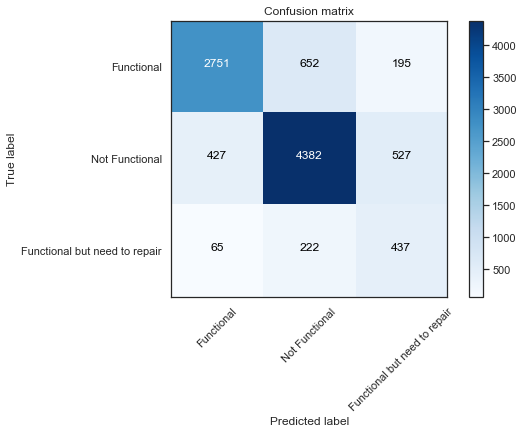

In [113]:
import itertools
plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [114]:
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [115]:
precision=metrics.precision_score(y_test, y_pred,average='weighted')
recall=metrics.recall_score(y_test, y_pred,average='weighted')
precision,recall

(0.8049102480129322, 0.7838061710499068)

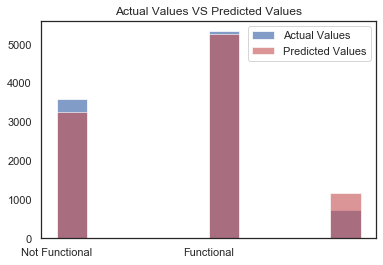

In [116]:
plt.hist(y_test,alpha=0.7,color='b',label='Actual Values')
plt.hist(smote_pred,alpha=0.6,color='r',label='Predicted Values')
plt.title('Actual Values VS Predicted Values')
plt.xticks([0, 1],['Not Functional', 'Functional'])
plt.legend()
plt.show()

# Feature Importance

In [118]:
importances = rfc.feature_importances_

feature_importance=pd.DataFrame()
feature_importance['feature']=x_train.columns
feature_importance['weight']=importances 
table=feature_importance.sort_values(by='weight',ascending=False)
table

,feature,weight
5,longitude,0.139096
26,quantity,0.113656
6,latitude,0.108853
3,gps_height,0.066438
12,ward,0.051194
2,funder,0.044524
13,population,0.043547
11,lga,0.039097
4,installer,0.036649
30,waterpoint_type,0.035367


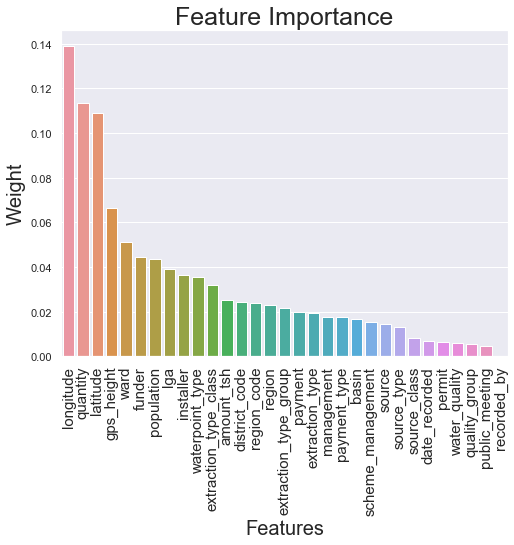

In [264]:
plt.figure(figsize=(8,6))
sns.barplot(table['feature'],table['weight'])
plt.xticks(np.arange(len(x_train.columns)),rotation=90,size=15)
plt.title('Feature Importance',fontsize=25)
plt.xlabel('Features',fontsize=20)
plt.ylabel('Weight',fontsize=20)
plt.show()